# Create a conditional generative adversarial network (GAN)

![](GAN.png)

Here we will create a conditional GAN (cGAN) based on two vanilla artificial neural networks. Briefly, a cGAN consists of two competing neural networks, a generator $G$ and a discriminator $D$. The generator takes random noise ${\bf z}$ as input (i.i.d. standard Gaussians here) and a class label and aims to learn a distribution of the data over ${\bf z}$, conditioned on the class label ${\bf c}$. To do so it must learn to fool the discriminator into thinking that fake $G({\bf z}\mid{\bf c})$ samples were drawn from the data distribution $p({\bf x} \mid {\bf c})$, ${\bf x}$ being a real data sample.

The discriminator is the only network that has access to real data samples, and its job is to predict the probability that a sample is real. As $D$ is in competition with $G$, it aims to maximize $D({\bf x}\mid{\bf c})$ and minimize $D(G({\bf z}\mid{\bf c}))$. $G$ wants to maximize $D(G({\bf z}\mid{\bf c}))$. This can be done by minimizing the binary cross entropy loss function shown above. While training the discriminator, the minibatch consists of both real and fake samples, setting $y_i=1$ for the former and 0 for the latter. 

When training the generator, all samples are fake, and $G$ "lies" to the discriminator by setting $y_1 = 1$. Note from the figure above that $G$ is trained with the loss gradient coming from $D$, as it cannot learn from the data directly. Although this loss gradient is back propagated through $D$, it is **only** used to update the weights of $G$.

For more info, see e.g.:

* Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.

For the unconditional GAN tutorial, see `tutorials/GAN`.

======================================================================================================================

Uncomment the lines below if you need to install EasySurrogate, or emnist (the training data used here).

In [1]:
#!pip install easysurrogate
#!pip install emnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import easysurrogate as es
import pandas as pd
from tqdm import tqdm
from IPython import display
from easysurrogate.methods import Layer, Concatenate

from emnist import list_datasets, extract_training_samples

Here we define the discriminator network. The output layer has sigmoid activation which makes sure D always predicts a value between 0 and 1. The learning rate (`alpha`), momentum parameter (`beta1`) and activation of the hidden layers (`activation`) are set to common values used for training GANs.

We will scale the data to lie within $[-1, 1]$ and the output is already scaled to lie within $[0,1]$, so there is no need to standardize the training data (`standardize_X = standardize_y = False`).

Furthermore, note from the figure at the top that the class labels for both $G$ and $D$ are represent via a **separate** input layer. Thus, both feed into their own hidden layer, which are then combined one layer further. To set up this architecture we set up the idividual `Layer` objects, and feed these into the `ANN` objects. Combining the two hidden layers is done via a `Concatenate` layer. Briefly, this layer:

* has no activation of weights of its own, but;
* copies the activation of the previous connected layers in a feed forward pass,
* copies the loss gradient of the next layer in a back propagation pass, and passes the correspoding part of loss gradient to each concatenated layer.

In [3]:
def define_discriminator(X_train, n_neurons, n_label=1, batch_size = 32,
                         alpha = 0.0002, beta1 = 0.5):
    """
    Set up the Disriminator.

    Parameters
    ----------
    X_train : array (n_train, n_in)
        The training data.
    n_neurons : int or list
        The number of neurons for the hidden layers.
    batch_size : int, optional
        The size of 1 mini batch. The default is 32.
    alpha : float, optional
        The learning rate. The default is 0.0002.
    beta1 : float, optional
        Momentum parameter (coefficient moving average of loss gradient).
        The default is 0.5.

    Returns
    -------
    D : ANN
        The discrimonator network.

    """
    
    # input layer of D (size of 1 image)
    layer_in = Layer(n_out, 'linear', bias = False)
    # input layer for the (one-hot encoded) class label
    layer_label = Layer(n_label, 'linear', bias = False)
    # hidden layers
    layer_hidden1 = Layer(n_neurons[0], 'parametric_relu', relu_a = 0.2, bias=True)
    layer_hidden2 = Layer(n_neurons[1], 'parametric_relu', relu_a = 0.2, bias=True)
    layer_hidden3 = Layer(n_neurons[2], 'parametric_relu', relu_a = 0.2, bias=True)
    # concatenation layer
    layer_concat = Concatenate()
    # output layer
    layer_out = Layer(1, 'sigmoid', loss='binary_cross_entropy')

    # layer_in feeds into layer_hidden1
    layer_hidden1(layer_in)
    # layer_label feeds into layer_hidden2
    layer_hidden2(layer_label)
    # layer_hidden1 + layer_hidden2 are concatenated into a single hidden layer
    layer_concat([layer_hidden1, layer_hidden2])
    # layer_concat feeds into layer_hidden3
    layer_hidden3(layer_concat)
    # layer_hidden3 feeds into layer_out
    layer_out(layer_hidden3)

    # Create ANN, give dummy training data (X_train[0], None). Real data will be given in train subroutine
    D = es.methods.ANN(X_train[0], None, batch_size=batch_size,
                       alpha=alpha, beta1=beta1,
                       standardize_X=False, standardize_y=False,
                       layers=[layer_in, layer_hidden1, layer_label,
                               layer_hidden2, layer_concat,
                               layer_hidden3, layer_out])

    return D

We define the generator in a similar fashion. Since the output will be a data sample where each pixel lies within $[-1, 1]$, we select tanh as output activation.

In [4]:
def define_generator(n_neurons, n_out, n_latent, n_label=1,
                     batch_size = 32,
                     alpha = 0.0002, beta1 = 0.5):
    """
    Set up the generator.

    Parameters
    ----------
    n_neurons : int or list
        The number of neurons for the hidden layers.
    n_out : int
        The number of output neurons (=size data sample).
    n_latent : int
        The number of input neurons (=size latent space).
    batch_size : int, optional
        The size of 1 mini batch. The default is 32.
    alpha : float, optional
        The learning rate. The default is 0.0002.
    beta1 : float, optional
        Momentum parameter (coefficient moving average of loss gradient).
        The default is 0.5.

    Returns
    -------
    G : ANN
        The generator network.

    """
    # layer for the latent random noise
    layer_z = Layer(n_latent, 'linear', bias = False)
    # input layer for the (one-hot encoded) class label
    layer_label = Layer(n_label, 'linear', bias = False)
    # hidden layers
    layer_hidden1 = Layer(n_neurons[0], 'parametric_relu', relu_a=0.2, bias=True)
    layer_hidden2 = Layer(n_neurons[1], 'parametric_relu', relu_a=0.2, bias=True)
    layer_hidden3 = Layer(n_neurons[2], 'parametric_relu', relu_a=0.2, bias=True)
    # concatenation layer
    layer_concat = Concatenate()
    # output layer
    layer_out = Layer(n_out, 'tanh')

    # layer_z feeds into layer_hidden1
    layer_hidden1(layer_z)
    # layer_label feeds into layer_hidden2
    layer_hidden2(layer_label)
    # layer_hidden1 + layer_hidden2 are concatenated into a single hidden layer
    layer_concat([layer_hidden1, layer_hidden2])
    # layer_concat feeds into layer_hidden3
    layer_hidden3(layer_concat)
    # layer_hidden3 feeds into layer_out
    layer_out(layer_hidden3)

    # Create ANN, give dummy training data (X_train[0], None). Real data will be given in train subroutine
    G = es.methods.ANN(np.random.randn(1, n_latent + n_classes), None, batch_size=batch_size,
                        alpha=alpha, beta1=beta1,
                        standardize_X=False, standardize_y=False,
                        layers=[layer_z, layer_hidden1, layer_label,
                                layer_hidden2, layer_concat,
                                layer_hidden3, layer_out])
    return G



This subroutine randomly draws `n_samples` samples from the training data. It is used during training of D. As all samples are real, the corresponding labels $y_i$ are all equal to 1.

In [5]:
def generate_real_samples(X_train, n_samples):
    """
    Randomly select n_samples from the training data.

    Parameters
    ----------
    X_train : array (n_train, n_in)
        The training data.
    n_samples : int
        The number of samples to select.

    Returns
    -------
    real_img : array (n_samples, n_in)
        n_samples randomly selected training samples of size n_in.
    real_class_label : array (n_samples, n_classes)
        n_samples one-hot-encoded class labels of the selected training samples.
    y_i : array (n_samples, 1)
        Corresponding labels for binary_cross_entropy loss (all 1's).

    """

    rand_idx = np.random.randint(0, X_train.shape[0], n_samples)
    # real images + labels
    real_img = X_train[rand_idx]
    real_class_label = class_label[rand_idx]
    # labels for cross entropy, all ones as all samples come from data
    y_i = np.ones([n_samples, 1])

    return real_img, real_class_label, y_i

This subroutine randomly draws `n_samples` samples from G. It is used during training of D and G. As all samples are fake, the corresponding labels $y_i$ are all equal to 0.

In [6]:
def generate_fake_samples(G, n_samples):
    """
    Generate n_samples fake samples.

    Parameters
    ----------
    G : ANN
        The ganerator.
    n_samples : int
        The number of samples to generate.

    Returns
    -------
    fake : array (n_samples, n_in)
        n_samples randomly generated fake samples of size n_in.
    real_class_label : array (n_samples, n_classes)
        n_samples one-hot-encoded class labels of the generated fake samples.
    y_i : int 
        Corresponding labels for binary_cross_entropy loss (all 0's).

    """
    # sample the random latent space
    z = latent_space(G.n_in[0], n_samples)
    # select random class labels from {0, 1, 2, ..., n_classes}
    fake_class_label = np.random.randint(0, n_classes, n_samples).reshape([-1,1]) 
    # turn integer classes into one-hot encoded data
    fake_class_label = feat_eng.bin_data(fake_class_label, n_classes)
    # generate fake samples
    fake_img = G.feed_forward([z, fake_class_label], n_samples).T
    # labels for cross entropy, all zeros as all samples are fake
    y_i = np.zeros([n_samples, 1])

    return fake_img, fake_class_label, y_i

This subroutine just returns a random sample ${\bf z}\sim p({\bf z})$.

In [7]:
def latent_space(n_latent, n_samples):
    """
    Sample the latent space

    Parameters
    ----------
    n_latent : int
        The dimension of the latent space.
    n_samples : int
        The number of samples.

    Returns
    -------
    array (n_samples, n_latent)
        n_samples x n_latent draws from iid standard Gaussians.

    """

    return np.random.randn(n_samples, n_latent)

This subroutine trains the GAN. During each mini batch:

* D is trained first on a set of real and fake samples. 
* Then, G is trained using fake samples only, and by "lying" to D by setting $y_i=1$. 
* This loss is then propagated through D by calling `D.batch(G_i, y_i.T)`. We do not call `D.update_weights` as we do not want the weights of D to be updated with this false loss gradient. 
* By calling `G.back_prop(y_i)` we propagate the loss fruther from the input layer of D though all layers of G, and subsequently we do update the weights of G.
* Some on-the-fly plotting is done by calling the `draw` function every `n_draw` mini-batch iterations.


In [8]:
def train(n_batch, batch_size, G, D, X_train, n_draw = 1000):
    """
    Train a cGAN.

    Parameters
    ----------
    n_batch : int
        The total number of mini batch iterations
    batch_size : int
        The size of 1 mini batch.
    G : ANN
        The generator.
    D : ANN
        The discriminator.
    X_train : array (n_train, n_in)
        The training data.

    Returns
    -------
    None.

    """

    # half the batch size
    half_batch = int(batch_size / 2)
    # the learning rate
    alpha = G.alpha

    for n in tqdm(range(n_batch)):

        D.set_batch_size(half_batch)

        # generate half_batch real samples
        real, real_class, real_labels = generate_real_samples(X_train, half_batch)
        D.batch([real, real_class], real_labels.T)
        D.update_weights(alpha)

        # generate half_batch fake samples
        fake, fake_class, fake_labels = generate_fake_samples(G, half_batch)
        D.batch([fake, fake_class], fake_labels.T)
        D.update_weights(alpha)

        # average probability that X_i came from the data
        prob_vals_D.append(np.mean(D.get_last_prediction()))

        D.set_batch_size(batch_size)

        # generate fake samples, do not return the true labels
        G_i, fake_class, _ = generate_fake_samples(G, batch_size)            
        # create false labels, to 'lie' to the Discriminator
        y_i = np.ones([batch_size, 1])
        # feed fake samples to D, telling D they come from the data,
        # batch computes loss gradient but does not update weights of D
        D.batch([G_i, fake_class], y_i.T)
        # back propagates loss from D through G
        G.back_prop(y_i)

        # update the weights of the Generator
        G.update_weights(alpha)

        # average probability that G_i came from the data
        prob_vals_G.append(np.mean(D.layers[-1].h))

        # show pobabilities during training
        if np.mod(n, n_draw) == 0: draw(G)

This does as the doc string suggests.

In [9]:
def draw(G):
    """
    Draw stuff on screen while training.

    Returns
    -------
    None.

    """
    plt.clf()
    display.clear_output(wait=True) # required to make plot update work in Jupyter notebook

    gs = GridSpec(5, 10, figure=fig)

    ax = fig.add_subplot(gs[:, 0:5], ylabel='probability', xlabel='batch')
    ax.plot(prob_vals_D, label=r'$D(X, G(z)|c)$')
    ax.plot(prob_vals_G, label=r'$D(G(z)|c)$')
    plt.legend()

    I, J = 5, 5
    idx = 0
    for i in range(I):
        for j in range(J):
            # ax = fig.add_subplot(I, J, idx + 1, xticks=[], yticks=[])       
            ax = fig.add_subplot(gs[i, j + 5], xticks=[], yticks=[])       
            idx += 1
            # predict for a fixed class label
            img = G.feed_forward([latent_space(n_latent, 1), class_label[0].reshape([1, -1])])
            ax.imshow(img.reshape([image_size, image_size]))
    plt.tight_layout()

    display.display(fig) # required to make plot update work in Jupyter notebook

Call this to draw random data samples.

In [10]:
def draw_data_points():
    """
    plot 4 random data points
    
    """
    idx = np.random.randint(0, X_train.shape[0], size = 4)
    fig_ = plt.figure()
    for count, i in enumerate(idx):
        ax = fig_.add_subplot(2, 2, count + 1, xticks=[], yticks=[])    
        ax.imshow(X_train[i].reshape([image_size, image_size]))
    plt.tight_layout()

The following data sets are available from the emnist package:

In [11]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

We will use the standard 28 x 28 MNIST hand-written number images as training data. If you also would like to include letters, select the `'balanced'` data set instead. As mentioned we will scale the data to lie in $[-1, 1]$.

In [12]:
X_train, class_label = extract_training_samples('mnist')
image_size = 28 # width and length
# Scale data to [-1, 1] (= range tanh activation)
X_train = X_train / 255 * 2 - 1
X_train = X_train.reshape(-1, image_size ** 2)

# number of classes
n_classes = np.unique(class_label).size
# one-hot encoded class labels
feat_eng = es.methods.Feature_Engineering()
class_label = feat_eng.bin_data(class_label, n_classes)

Creating Feature Engineering object


Plot some training data samples ${\bf x}$.

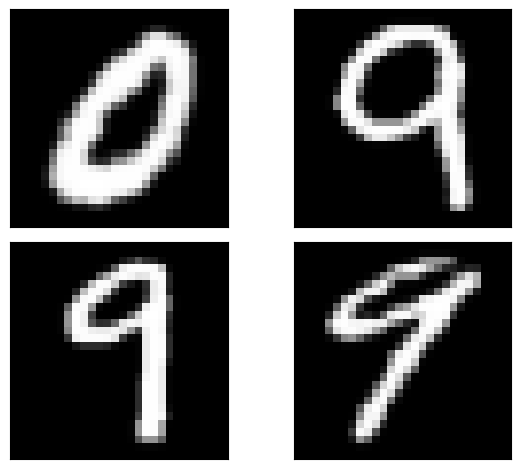

In [13]:
plt.rcParams['image.cmap'] = 'Greys_r'
draw_data_points()

Set some parameters:

In [14]:
# number of desired epochs
n_epochs = 10
# number of training samples
n_train = X_train.shape[0]
# size of 1 mini batch
batch_size = 32
# number of mini batch iterations for 1 epoch
epoch = int(n_train / batch_size)
# number of mini batch iterations for n_epoch epochs
n_iter = epoch * n_epochs
# dimension latent space
n_latent = 100
# size of 1 training sample
n_out = image_size ** 2

Define G and D using the subroutines above

In [15]:
G = define_generator(n_neurons = [256, 50, 512], 
                     n_out = n_out,
                     n_latent = n_latent, n_label=n_classes,
                     batch_size = batch_size)

D = define_discriminator(X_train, 
                         n_neurons = [512, 50, 256], n_label=n_classes,
                         batch_size = batch_size)

Neural net parameters
Number of layers = 6
Number of features = [100, 10]
Loss function = None
Number of neurons per hidden layer = [256, 50, 308, 512]
Number of output neurons = 1
Activation = ['linear', 'parametric_relu', 'linear', 'parametric_relu', None, 'parametric_relu', 'tanh']
This neural network has 585988 weights.
Neural net parameters
Number of layers = 6
Number of features = [784, 10]
Loss function = binary_cross_entropy
Number of neurons per hidden layer = [512, 50, 564, 256]
Number of output neurons = 1
Activation = ['linear', 'parametric_relu', 'linear', 'parametric_relu', None, 'parametric_relu', 'sigmoid']
This neural network has 546549 weights.


### Important:

Since G is trained with the loss gradient coming from D, the output layer of G must be connected to the input later of D. Set `layer_rp1` ($\mathrm{layer}_{r+1}$) attribute of G's output layer to D's input layer. Once this is done the loss gradient from D will flow to G when calling `G.back_prop` in the `train` subroutine.

In [16]:
G.layers[-1].layer_rp1 = D.layers[0]

Some lists used in the `draw` subroutine.

In [17]:
prob_vals_D = []
prob_vals_G = []

Train the cGAN. You will need many iterations to get nice clean $G({\bf z}\mid{\bf c})$ samples from the generator, although quite soon the outputs will be recognizable as numbers. The left subplot shows the probability $D({\bf x}, G({\bf z})\mid{\bf c})$  and $D(G({\bf z})\mid{\bf c})$ for each mini batch. The first one is the probability of the discriminator batch (averaged over the batch size), which contained both real and fake samples. The second one is the probability of the generator batch, containing only fake samples. You will notice that the probabilities will stabilize away from the extremes (0 and 1), which is desirable as it denotes a "stable" GAN. $D$ and $G$ need to learn from each other, and $D(G({\bf z})\mid{\bf c})=1$ would mean $G$ is always able to fool the discriminator. Likewise, $D({\bf x}, G({\bf z})\mid{\bf c})=0.5)$ (or $D(G({\bf z})\mid{\bf c})=0$) indicates that $D$ is too good, i.e. always able to tell the difference between real and fake, such that no gradient flows back to $G$. In other words, unlike other network types, the goal here is thus not to bring the loss function to zero. An equilibrium away from zero needs to be reached, allowing both $D$ and $G$ to learn when given sufficient training time.

The `draw` subroutine shows the predictions conditioned on a fixed class label, i.e. that of the first training sample. Unlike with the GAN tutorial, after some time the same digit should therefore appear.

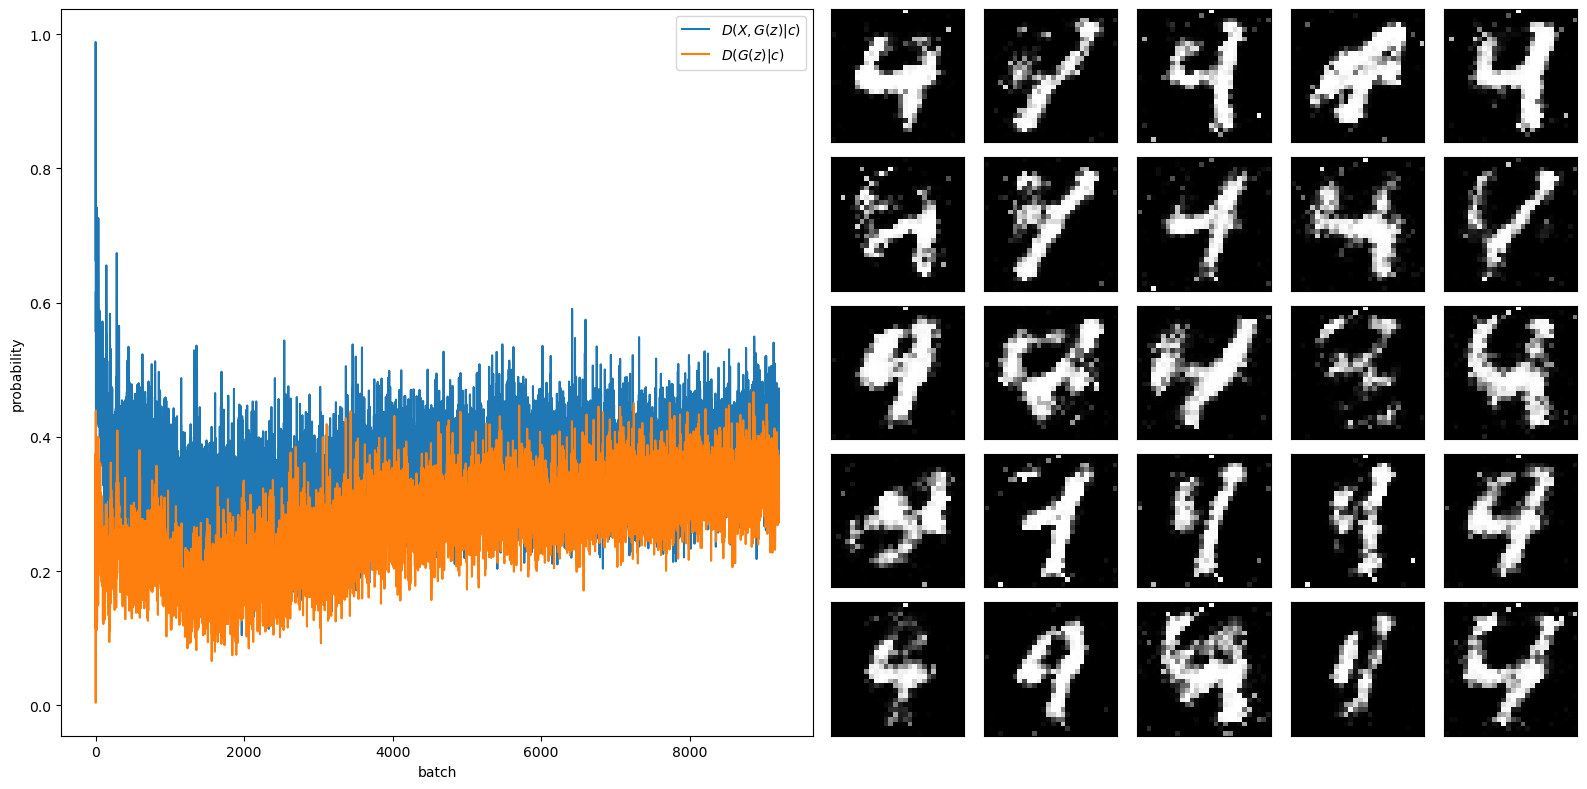

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:27<00:00, 17.62it/s]


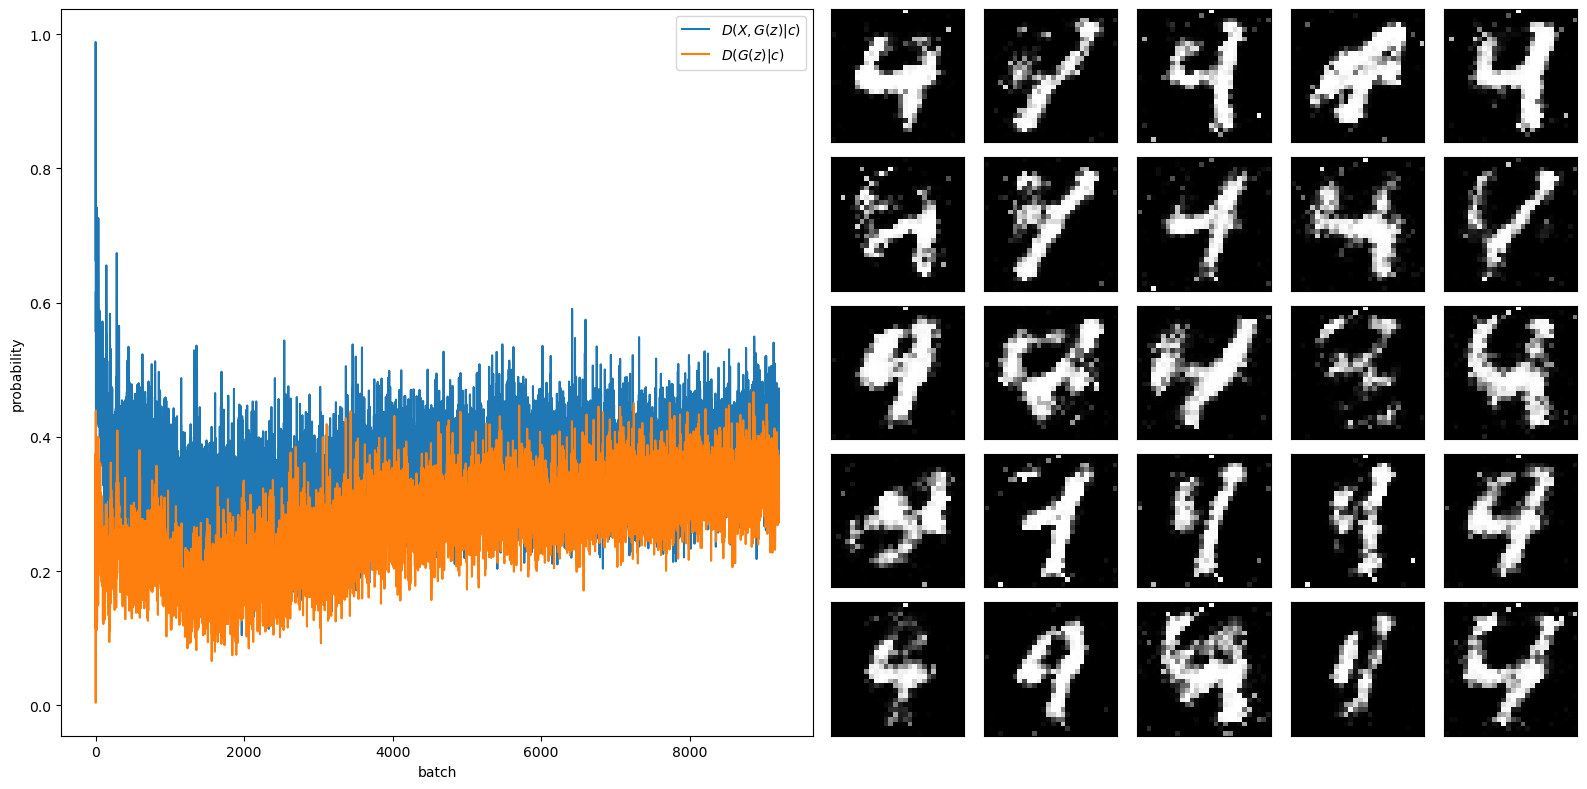

In [20]:
%matplotlib inline
# select to run for n_epochs epochs
# n_batch = n_iter
# manually specify the number of mini-batch iterations
n_batch = 10000
fig = plt.figure(figsize=[16,8])
train(n_batch, batch_size, G, D, X_train, n_draw = 1000)